## HMM built-in check + Posterior predictive check (random-based)

Load the trained model

In [14]:
# Add src directory to Python path
import sys
import os
import numpy as np
import pickle
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import (HMM_MODEL_PATH, PLOT_SAVE_PATH)
from src.hmm_surrogate import HMMSurrogate

from src.convergence_utils import (plot_log_likelihoods, 
    save_convergence_data, plot_state_chain_acf, 
    posterior_predictive_check, mean_run_length,
    simulate_state_sequences,posterior_predictive_check_model_based)

hmm_surrogate_model = HMMSurrogate()
hmm_surrogate_model.load_model(HMM_MODEL_PATH)

# load decoded train states
with open("convergence_diagnostics/valid_decoded_train_states.pkl", "rb") as f:
    valid_decoded_train_states = pickle.load(f)

HMM model loaded from models/sentiment_hmm25k_4states.pkl

--- HMM Parameters ---
Initial state probabilities (startprob_):
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 5.37242129e-283]

Transition matrix (transmat_):
 [[9.96086421e-01 0.00000000e+00 7.78136453e-07 3.91280045e-03]
 [8.73818280e-04 0.00000000e+00 7.26633199e-03 9.91859850e-01]
 [4.06340986e-05 0.00000000e+00 9.94756391e-01 5.20297473e-03]
 [7.00619751e-03 2.10316161e-41 8.11990557e-03 9.84873897e-01]]

Emission probabilities (means_ for GaussianHMM):
 [[0.98723543 0.01276457]
 [0.35785007 0.64214998]
 [0.01603069 0.98396931]
 [0.49455074 0.50544926]]

Emission covariances (covars_ for GaussianHMM):
 [[[ 8.09619411e-05 -8.09525074e-05]
  [-8.09525074e-05  8.09619414e-05]]

 [[ 4.00000000e-07  3.99999948e-07]
  [ 3.99999948e-07  3.99999912e-07]]

 [[ 1.33502958e-04 -1.33493685e-04]
  [-1.33493685e-04  1.33502958e-04]]

 [[ 1.13576994e-01 -1.13576986e-01]
  [-1.13576986e-01  1.13576994e-01]]]


Check if our observed sequences significantly differ from random permutations (!! not sure about the utility/relevance of this).
[Useful reference for understanding the topic](https://stats.stackexchange.com/questions/115157/what-are-posterior-predictive-checks-and-what-makes-them-useful)


--- HMM Convergence Check ---
Converged: True
Number of iterations: 55
Tolerance: 0.0001
Final log-likelihood: 67862697.4412


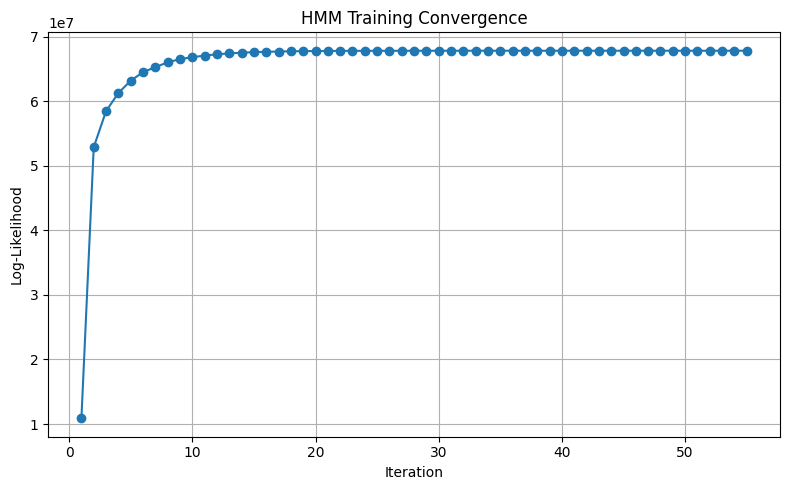

Convergence plot saved to 'notebooks/plots'.
Convergence data saved to 'convergence_diagnostics/convergence_data.pkl'.


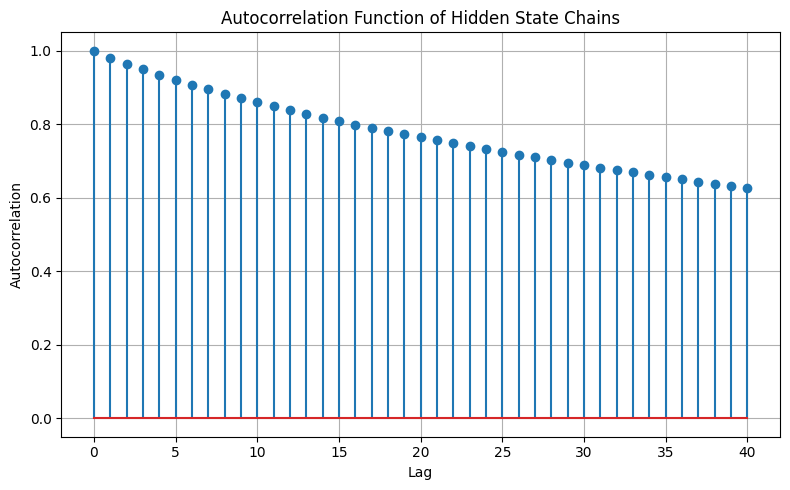

ACF plot saved to 'convergence_diagnostics/state_chain_acf.png'.
Observed summary: 71.481
Mean simulated summary: 11.396
Posterior predictive p-value: 0.028
Posterior predictive p-value for mean run length: 0.028


In [15]:
convergence_diagnostics = None

if hmm_surrogate_model and hmm_surrogate_model.is_trained:
    convergence_diagnostics = hmm_surrogate_model.check_convergence()
    plot_log_likelihoods(convergence_diagnostics["log_likelihoods"], convergence_diagnostics["n_iter"], save_path=PLOT_SAVE_PATH)
    save_convergence_data(convergence_diagnostics)    

if valid_decoded_train_states:
    # Plot autocorrelation of hidden state chains
    plot_state_chain_acf(valid_decoded_train_states, max_lag=40, save_path="convergence_diagnostics/state_chain_acf.png")
    
    assert np.all(np.array([len(i) for i in valid_decoded_train_states]) > 0), "some state sequences have length 0"
    # Posterior predictive check for mean run length
    observed_mean_run_length = np.mean([mean_run_length(seq) for seq in valid_decoded_train_states])
    p_value, simulated_summaries = posterior_predictive_check(
        valid_decoded_train_states,
        summary_func=mean_run_length,
        observed_value=observed_mean_run_length,
        num_simulations=1000
    )
    print(f"Posterior predictive p-value for mean run length: {p_value:.3f}")

# Posterior predictive check (model-generated samples)
Check if our trained model can faithfully simulate sequences of states similar to those observed in the data 
One would expect this to be quite persistent: transitions between states are rare due to the sequential structure of language. 

In [ ]:
if valid_decoded_train_states:
    sequence_lengths = [len(seq) for seq in valid_decoded_train_states]
    
    # Generate simulated sequences from the trained model
    simulated_sequences = simulate_state_sequences(
        hmm_model=hmm_surrogate_model.model,
        sequence_lengths=sequence_lengths,
        num_simulations=100
    )
    
    # Compute the observed summary statistic
    observed_mean_run_length = np.mean([
        mean_run_length(seq) for seq in valid_decoded_train_states
    ])
    
    # Run the PPC with model-based simulations
    p_value, simulated_summaries = posterior_predictive_check_model_based(
        observed_state_sequences=valid_decoded_train_states,
        simulated_state_sequences=simulated_sequences,
        summary_func=mean_run_length,
        observed_value=observed_mean_run_length
    )
    
    print(f"Model-based posterior predictive p-value for mean run length: {p_value:.3f}")

What does this mean? 
Our simulated data is not significantly different from observed data in terms of state persistence: the model is very sticky and this reflects also in the simulated data, with an average sequence length with the same token of 52. 
### This corroborates our convergence analysis, and we can say that the HMM model with 4 states captures the structure of sentiment change in the transformer quite well.